<a href="https://colab.research.google.com/github/anovick1/BraTS-MEN/blob/main/BraTS_Men.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install and imports

In [ ]:
!pip -q install monai nibabel torchmetrics

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, glob, time, json, random, numpy as np, torch, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

from monai.data import Dataset, list_data_collate, decollate_batch
from monai.networks.nets import UNet
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, Spacingd,
    NormalizeIntensityd, RandFlipd, RandRotate90d, ConcatItemsd, ToTensord,
    RandCropByPosNegLabeld, MapTransform, AsDiscrete,
    KeepLargestConnectedComponent, FillHoles
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

import monai
monai.utils.set_determinism(42)
torch.backends.cudnn.benchmark = True

SAVE_DIR = Path("/content/drive/MyDrive/BraTS_MEN_baseline_v2")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
print("Saving to:", SAVE_DIR)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 64.8 MB/s eta 0:00:00
Mounted at /content/drive
Device: cuda
Saving to: /content/drive/MyDrive/BraTS_MEN_baseline_v2


Path and Index the dataset (4 inputs and 1 mask per subject)

In [ ]:
# Copy once per session (fast local I/O)
!rsync -a --info=progress2 "/content/drive/MyDrive/BraTS2023_MEN_Data/BraTS-MEN-Train/" "/content/BraTS-MEN-Train/"

LOCAL_TRAIN_ROOT = "/content/BraTS-MEN-Train"
DRIVE_TRAIN_ROOT = "/content/drive/MyDrive/BraTS2023_MEN_Data/BraTS-MEN-Train"
TRAIN_ROOT = LOCAL_TRAIN_ROOT if os.path.isdir(LOCAL_TRAIN_ROOT) else DRIVE_TRAIN_ROOT
print("Using TRAIN_ROOT:", TRAIN_ROOT)

# Robust file patterns
F_PATTERNS = {
    "t1n": ["*t1n.nii.gz", "*t1.nii.gz"],
    "t2w": ["*t2w.nii.gz", "*t2.nii.gz"],
    "t2f": ["*t2f.nii.gz", "*flair.nii.gz", "*t2flair.nii.gz", "*flair*nii.gz"],
    "t1c": ["*t1c.nii.gz", "*t1ce.nii.gz", "*t1ce*nii.gz"],
    "seg": ["*seg.nii.gz", "*mask.nii.gz", "*segmentation.nii.gz"],
}

def find_one(patterns, folder):
    for pat in patterns:
        hits = list(Path(folder).glob(pat))
        if hits: return str(hits[0])
    return None

def collect_subject_dicts(train_root):
    subs = sorted([p for p in Path(train_root).glob("BraTS-MEN-*") if p.is_dir()])
    items, miss = [], 0
    for sd in subs:
        d = {k: find_one(v, sd) for k, v in F_PATTERNS.items()}
        if all(d.values()): items.append(d)
        else: miss += 1
    print(f"Total subject dirs: {len(subs)} | usable: {len(items)} | missing: {miss}")
    return items

split_path = SAVE_DIR / "subject_split.json"

if split_path.exists():
    print("Loading existing split:", split_path)
    payload = json.loads(Path(split_path).read_text())
    train_items, val_items = payload["train"], payload["val"]
else:
    print("Creating new split…")
    all_items = collect_subject_dicts(TRAIN_ROOT)
    random.seed(42); random.shuffle(all_items)
    split = int(0.8 * len(all_items))
    train_items, val_items = all_items[:split], all_items[split:]
    # ensure at least one FG in val
    import nibabel as nib
    def has_fg(it):
        try: return (nib.load(it["seg"]).get_fdata() > 0).any()
        except: return False
    if not any(has_fg(v) for v in val_items[:min(20,len(val_items))]):
        for j,it in enumerate(train_items[:200]):
            if has_fg(it):
                val_items = [it] + val_items
                train_items = train_items[:j]+train_items[j+1:]
                print("[Adjust] moved FG case to val"); break
    payload = {"train_root": TRAIN_ROOT, "train": train_items, "val": val_items}
    Path(split_path).write_text(json.dumps(payload, indent=2))
    print("Saved split to:", split_path)

print(f"Train subjects: {len(train_items)} | Val subjects: {len(val_items)}")


 20,695,540,133 100%    5.70MB/s    0:57:40 (xfr#5000, to-chk=0/6001)
Using TRAIN_ROOT: /content/BraTS-MEN-Train
Creating new split…
Total subject dirs: 1000 | usable: 1000 | missing: 0
Saved split to: /content/drive/MyDrive/BraTS_MEN_baseline_v2/subject_split.json
Train subjects: 800 | Val subjects: 200


Transforms (spacing, binarize, crops/aug)

In [ ]:
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, Spacingd,
    NormalizeIntensityd, RandFlipd, RandRotate90d, ConcatItemsd, ToTensord,
    RandCropByPosNegLabeld, MapTransform
)

# binarize seg -> {0,1}
class BinarizeSeg(MapTransform):
    def __init__(self, keys=("seg",), allow_missing_keys=False):
        super().__init__(keys, allow_missing_keys)
    def __call__(self, data):
        import torch as _T, numpy as _N
        d = dict(data)
        for k in self.keys:
            y = d[k]
            if isinstance(y, _T.Tensor): d[k] = (y > 0).float()
            else: d[k] = (_N.asarray(y) > 0).astype(_N.float32)
        return d

keys_img = ["t1n","t2w","t2f","t1c"]
key_seg  = "seg"
ROI = (128,128,128)  # A100 should handle this

_common = [
    LoadImaged(keys=keys_img+[key_seg], image_only=True),
    EnsureTyped(keys=keys_img+[key_seg]),
    EnsureChannelFirstd(keys=keys_img+[key_seg]),
    Spacingd(keys=keys_img, pixdim=(1,1,1), mode="bilinear"),
    Spacingd(keys=[key_seg],  pixdim=(1,1,1), mode="nearest"),
    BinarizeSeg(keys=(key_seg,)),
    NormalizeIntensityd(keys=keys_img, nonzero=True, channel_wise=True),
]

train_transforms = Compose(_common + [
    RandCropByPosNegLabeld(keys=keys_img+[key_seg], label_key=key_seg,
                           spatial_size=ROI, pos=2, neg=1, num_samples=2),
    RandFlipd(keys=keys_img+[key_seg], spatial_axis=[0,1,2], prob=0.5),
    RandRotate90d(keys=keys_img+[key_seg], prob=0.2, max_k=3),
    ConcatItemsd(keys=keys_img, name="image", dim=0),
    ToTensord(keys=["image", key_seg]),
])

val_transforms = Compose(_common + [
    ConcatItemsd(keys=keys_img, name="image", dim=0),
    ToTensord(keys=["image", key_seg]),
])



Dataset and Loaders

In [ ]:
from monai.data import Dataset, list_data_collate
from torch.utils.data import DataLoader

train_ds = Dataset(train_items, transform=train_transforms)
val_ds   = Dataset(val_items,   transform=val_transforms)

train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True,
    num_workers=4, pin_memory=True, persistent_workers=True,
    collate_fn=list_data_collate
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False,
    num_workers=4, pin_memory=True, persistent_workers=True,
    collate_fn=list_data_collate
)

print("len(train_ds) =", len(train_ds), "| len(val_ds) =", len(val_ds))



len(train_ds) = 800 | len(val_ds) = 200


Model, Loss, Optimizer, Metrics

In [ ]:
from monai.networks.nets import UNet
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.transforms import AsDiscrete

model = UNet(
    spatial_dims=3, in_channels=4, out_channels=1,
    channels=(32,64,128,256,512), strides=(2,2,2,2), num_res_units=2
).to(device)

loss_fn   = DiceCELoss(sigmoid=True, squared_pred=True)  # Dice + CE
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=5)

dice_metric = DiceMetric(include_background=False, reduction="mean")

# New AMP API
scaler  = torch.amp.GradScaler('cuda', enabled=(device.type=='cuda'))
ampctx  = lambda: torch.amp.autocast('cuda', enabled=(device.type=='cuda'))

# Post-processing used for validation metric
post_proc = Compose([
    AsDiscrete(threshold=0.60),
    KeepLargestConnectedComponent(applied_labels=[1]),
    FillHoles(applied_labels=[1]),
])



Training and Validation, save model and chart to drive

Checkpoint will be saved to: /content/drive/MyDrive/BraTS_MEN_baseline_v2/unet3d_v2.pt
[Epoch 1/40] Batch 0/800 loss=1.9776
[Epoch 1/40] Batch 50/800 loss=1.8352
[Epoch 1/40] Batch 100/800 loss=1.7692
[Epoch 1/40] Batch 150/800 loss=1.8065
[Epoch 1/40] Batch 200/800 loss=1.8172
[Epoch 1/40] Batch 250/800 loss=1.7649
[Epoch 1/40] Batch 300/800 loss=1.3418
[Epoch 1/40] Batch 350/800 loss=1.7815
[Epoch 1/40] Batch 400/800 loss=1.6457
[Epoch 1/40] Batch 450/800 loss=1.7632
[Epoch 1/40] Batch 500/800 loss=1.7551
[Epoch 1/40] Batch 550/800 loss=1.7496
[Epoch 1/40] Batch 600/800 loss=1.4833
[Epoch 1/40] Batch 650/800 loss=1.7608
[Epoch 1/40] Batch 700/800 loss=1.7624
[Epoch 1/40] Batch 750/800 loss=1.5016


/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  out

Epoch 01 | train loss: 1.6926 | val Dice: 0.3585 | 579.5s
  ✓ New best, saved to: /content/drive/MyDrive/BraTS_MEN_baseline_v2/unet3d_v2.pt
[Epoch 2/40] Batch 0/800 loss=1.6745
[Epoch 2/40] Batch 50/800 loss=1.7535
[Epoch 2/40] Batch 100/800 loss=1.6924
[Epoch 2/40] Batch 150/800 loss=1.7349
[Epoch 2/40] Batch 200/800 loss=1.3269
[Epoch 2/40] Batch 250/800 loss=1.7376
[Epoch 2/40] Batch 300/800 loss=1.5940
[Epoch 2/40] Batch 350/800 loss=1.3374
[Epoch 2/40] Batch 400/800 loss=1.7173
[Epoch 2/40] Batch 450/800 loss=1.7348
[Epoch 2/40] Batch 500/800 loss=1.7073
[Epoch 2/40] Batch 550/800 loss=1.6222
[Epoch 2/40] Batch 600/800 loss=1.6150
[Epoch 2/40] Batch 650/800 loss=1.4648
[Epoch 2/40] Batch 700/800 loss=1.6930
[Epoch 2/40] Batch 750/800 loss=1.4642
Epoch 02 | train loss: 1.6167 | val Dice: 0.5148 | 571.1s
  ✓ New best, saved to: /content/drive/MyDrive/BraTS_MEN_baseline_v2/unet3d_v2.pt
[Epoch 3/40] Batch 0/800 loss=1.7120
[Epoch 3/40] Batch 50/800 loss=1.4437
[Epoch 3/40] Batch 100/8

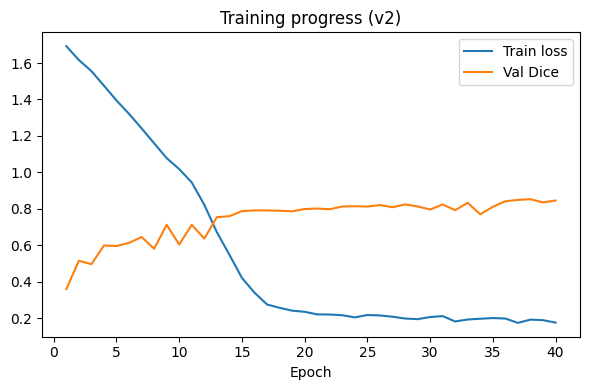

Curves saved: /content/drive/MyDrive/BraTS_MEN_baseline_v2/learning_curves_v2.png


In [ ]:
from monai.inferers import sliding_window_inference
import matplotlib.pyplot as plt, time
from pathlib import Path

EPOCHS   = 40
PATIENCE = 10
best_dice, wait = 0.0, 0
train_history, val_history = [], []

CKPT_PATH = SAVE_DIR / "unet3d_v2.pt"
print("Checkpoint will be saved to:", CKPT_PATH)

for epoch in range(1, EPOCHS+1):
    model.train()
    t0, running = time.time(), 0.0

    for i, batch in enumerate(train_loader):
        imgs = batch["image"].to(device)
        segs = batch["seg"].to(device).float()

        optimizer.zero_grad(set_to_none=True)
        with ampctx():
            logits = model(imgs)
            loss = loss_fn(logits, segs)

        if not torch.isfinite(loss):
            print(f"[Warn] non-finite loss at epoch {epoch} batch {i}; skipping")
            continue

        scaler.scale(loss).backward()
        # gradient clipping (stability)
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()

        running += float(loss.item())
        if i % 50 == 0:
            print(f"[Epoch {epoch}/{EPOCHS}] Batch {i}/{len(train_loader)} loss={loss.item():.4f}")

    train_loss = running / max(1, len(train_loader))
    train_history.append(train_loss)

    # ----- Validation -----
    model.eval(); dice_metric.reset()
    with torch.no_grad(), ampctx():
        for batch in val_loader:
            imgs = batch["image"].to(device)
            segs = batch["seg"].to(device).float()
            # fewer tiles with 128³; try 2 windows at once on A100
            logits = sliding_window_inference(
                imgs, ROI, sw_batch_size=2, predictor=model, overlap=0.25
            )
            probs = torch.sigmoid(logits)
            preds = post_proc(probs)            # apply threshold + LCC + fill holes
            dice_metric(preds, segs)

    val_dice = dice_metric.aggregate().item()
    val_history.append(val_dice)
    scheduler.step(val_dice)

    dt = time.time() - t0
    print(f"Epoch {epoch:02d} | train loss: {train_loss:.4f} | val Dice: {val_dice:.4f} | {dt:.1f}s")

    if val_dice > best_dice:
        best_dice, wait = val_dice, 0
        torch.save(model.state_dict(), CKPT_PATH)
        print("  ✓ New best, saved to:", CKPT_PATH)
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping.")
            break

print("Best val Dice (v2):", best_dice)


# Save learning curves
plt.figure(figsize=(6,4))
plt.plot(range(1,len(train_history)+1), train_history, label="Train loss")
plt.plot(range(1,len(val_history)+1),   val_history,   label="Val Dice")
plt.xlabel("Epoch"); plt.title("Training progress (v2)"); plt.legend(); plt.tight_layout()
plot_path = SAVE_DIR / "learning_curves_v2.png"
plt.savefig(plot_path, dpi=150); plt.show()
print("Curves saved:", plot_path)



Inference on a full subject w overlay (PNG to Drive)



Per-case Dice saved: /content/drive/MyDrive/BraTS_MEN_baseline_v2/val_dice_per_case_v2.csv | mean: 0.8525531632080674


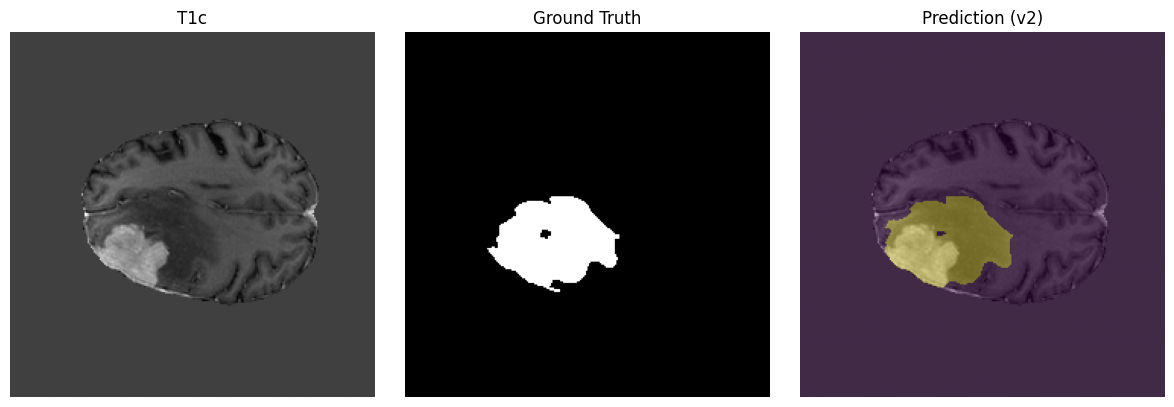

Overlay saved: /content/drive/MyDrive/BraTS_MEN_baseline_v2/val_overlay_v2.png


In [ ]:
# ===== Post-run quick eval + overlay (safe to run now) =====
import numpy as np
import torch
import matplotlib.pyplot as plt
from monai.transforms import Compose, AsDiscrete, KeepLargestConnectedComponent, FillHoles, ConcatItemsd, ToTensord
from monai.inferers import sliding_window_inference

# reload best and score per-case with the same post-proc
model.load_state_dict(torch.load(CKPT_PATH, map_location=device))
model.eval()

per_case = []
with torch.no_grad(), ampctx():
    for batch in val_loader:
        imgs = batch["image"].to(device)
        segs = batch["seg"].to(device).float()
        logits = sliding_window_inference(imgs, ROI, sw_batch_size=2, predictor=model, overlap=0.25)
        probs  = torch.sigmoid(logits)
        preds  = post_proc(probs)
        d = DiceMetric(include_background=False, reduction="mean")(preds, segs).item()
        per_case.append(d)

import pandas as pd, numpy as np
df = pd.DataFrame({"dice": per_case})
df_path = SAVE_DIR / "val_dice_per_case_v2.csv"
df.to_csv(df_path, index=False)
print("Per-case Dice saved:", df_path, "| mean:", float(np.mean(per_case)))

# one overlay
from monai.transforms import ConcatItemsd, ToTensord
inf_tf = Compose(_common + [ConcatItemsd(keys=keys_img, name="image", dim=0), ToTensord(keys=["image", key_seg])])
sample = inf_tf(val_items[0])
img = sample["image"].unsqueeze(0).to(device)
gt  = sample["seg"].cpu().numpy()[0]
with torch.no_grad(), ampctx():
    logits = sliding_window_inference(img, ROI, sw_batch_size=2, predictor=model, overlap=0.25)
pred = post_proc(torch.sigmoid(logits))[0,0].cpu().numpy()

zs = np.where(gt.sum(axis=(0,1))>0)[0]
z = int(zs[len(zs)//2]) if len(zs) else gt.shape[2]//2
t1c = sample["image"].cpu().numpy()[3]
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(t1c[:,:,z], cmap="gray"); plt.title("T1c"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(gt[:,:,z],  cmap="gray"); plt.title("Ground Truth"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(t1c[:,:,z], cmap="gray"); plt.imshow(pred[:,:,z], alpha=0.35); plt.title("Prediction (v2)"); plt.axis("off")
overlay_path = SAVE_DIR / "val_overlay_v2.png"
plt.tight_layout(); plt.savefig(overlay_path, dpi=150); plt.show()
print("Overlay saved:", overlay_path)


Device: cuda
Using SAVE_DIR: /content/drive/MyDrive/BraTS_MEN_baseline_v2
Val subjects: 200


/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  out

[thr=0.50] N=200 | mean Dice=0.8509 | 278.6s
[thr=0.60] N=200 | mean Dice=0.8526 | 268.3s


/usr/local/lib/python3.12/dist-packages/monai/metrics/utils.py:332: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(


[thr=0.70] N=200 | mean Dice=0.8496 | 258.2s
=> Best threshold by mean Dice: 0.60 (mean Dice 0.8526)
Per-case metrics saved: /content/drive/MyDrive/BraTS_MEN_baseline_v2/val_metrics_thr0.60.csv
Summary JSON saved: /content/drive/MyDrive/BraTS_MEN_baseline_v2/val_summary_thr0.60.json
Quick means: {'dice': 0.8525531639067957, 'iou': 0.7928443303944516, 'precision': 0.8930068219818343, 'recall': 0.8397123692268518, 'hd95': 10.189372994303703, 'vol_pred_cc': 38.62873, 'vol_gt_cc': 38.94121, 'vol_abs_err_cc': 1.9829499999999995}


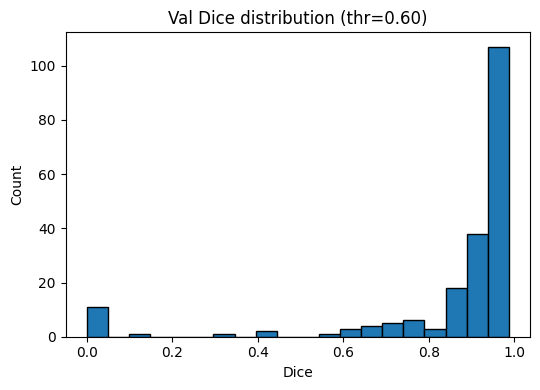

Dice hist saved: /content/drive/MyDrive/BraTS_MEN_baseline_v2/val_dice_hist_thr0.60.png
Saved all NIfTI predictions to: /content/drive/MyDrive/BraTS_MEN_baseline_v2/predictions_thr0.60
Overlay saved: /content/drive/MyDrive/BraTS_MEN_baseline_v2/overlays_thr0.60/BraTS-MEN-01176-000_worst.png
Overlay saved: /content/drive/MyDrive/BraTS_MEN_baseline_v2/overlays_thr0.60/BraTS-MEN-00805-000_median.png
Overlay saved: /content/drive/MyDrive/BraTS_MEN_baseline_v2/overlays_thr0.60/BraTS-MEN-00645-000_best.png

All done ✔


In [ ]:
# ========= Post-training deep analysis (val set) =========
# One cell: load checkpoint, evaluate, save everything important.

import os, json, glob, math, time, shutil, random
from pathlib import Path
import numpy as np
import nibabel as nib
import torch
import matplotlib.pyplot as plt

import monai
from monai.data import Dataset, DataLoader, list_data_collate
from monai.networks.nets import UNet
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.transforms import (
    Compose, LoadImaged, EnsureTyped, EnsureChannelFirstd, Spacingd,
    NormalizeIntensityd, ConcatItemsd, ToTensord, AsDiscrete,
    KeepLargestConnectedComponent, FillHoles
)

# -------------------
# Config / paths
# -------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Point to your v2 folder; change if needed
SAVE_DIR = Path(globals().get("SAVE_DIR", "/content/drive/MyDrive/BraTS_MEN_baseline_v2"))
CKPT_PATH = SAVE_DIR / "unet3d_v2.pt"
SPLIT_PATH = SAVE_DIR / "subject_split.json"
assert CKPT_PATH.exists(), f"Missing checkpoint: {CKPT_PATH}"
assert SPLIT_PATH.exists(), f"Missing split file: {SPLIT_PATH}"
print("Using SAVE_DIR:", SAVE_DIR)

# ROI and SWI params used in training
ROI = tuple(globals().get("ROI", (128,128,128)))
SW_OVERLAP = 0.25
SW_BATCH = 2
THR_CANDIDATES = [0.50, 0.60, 0.70]   # sweep these and pick best by mean Dice

# -------------------
# Data + transforms
# -------------------
payload = json.loads(Path(SPLIT_PATH).read_text())
val_items = payload["val"]

keys_img = ["t1n","t2w","t2f","t1c"]
key_seg  = "seg"

# helper: binarize mask after loading
def _binarize(arr):
    if isinstance(arr, torch.Tensor): return (arr > 0).float()
    return (np.asarray(arr) > 0).astype(np.float32)

class BinarizeSeg(monai.transforms.MapTransform):
    def __init__(self, keys=("seg",), allow_missing_keys=False):
        super().__init__(keys, allow_missing_keys)
    def __call__(self, data):
        d = dict(data)
        for k in self.keys: d[k] = _binarize(d[k])
        return d

_common = [
    LoadImaged(keys=keys_img+[key_seg], image_only=True),
    EnsureTyped(keys=keys_img+[key_seg]),
    EnsureChannelFirstd(keys=keys_img+[key_seg]),
    Spacingd(keys=keys_img, pixdim=(1,1,1), mode="bilinear"),
    Spacingd(keys=[key_seg],  pixdim=(1,1,1), mode="nearest"),
    BinarizeSeg(keys=(key_seg,)),
    NormalizeIntensityd(keys=keys_img, nonzero=True, channel_wise=True),
]

val_tf = Compose(_common + [
    ConcatItemsd(keys=keys_img, name="image", dim=0),
    ToTensord(keys=["image", key_seg]),
])

val_ds = Dataset(val_items, transform=val_tf)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False,
    num_workers=4, pin_memory=True, persistent_workers=False,  # be gentle on phone
    collate_fn=list_data_collate
)
print("Val subjects:", len(val_ds))

# -------------------
# Rebuild model + load weights
# -------------------
model = UNet(
    spatial_dims=3, in_channels=4, out_channels=1,
    channels=(32,64,128,256,512), strides=(2,2,2,2), num_res_units=2
).to(device)
state = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(state)
model.eval()

# AMP context (new API)
ampctx = lambda: torch.amp.autocast('cuda', enabled=(device.type=='cuda'))

# Post-processing block (applied AFTER threshold)
def build_postproc(thr):
    return Compose([
        AsDiscrete(threshold=float(thr)),
        KeepLargestConnectedComponent(applied_labels=[1]),
        FillHoles(applied_labels=[1]),
    ])

# -------------------
# Metric helpers
# -------------------
def dice_numpy(pred, gt, eps=1e-8):
    inter = np.logical_and(pred, gt).sum()
    return (2*inter) / (pred.sum() + gt.sum() + eps)

def iou_numpy(pred, gt, eps=1e-8):
    inter = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return inter / (union + eps)

def pr_numpy(pred, gt, eps=1e-8):
    tp = np.logical_and(pred, gt).sum()
    fp = np.logical_and(pred, np.logical_not(gt)).sum()
    fn = np.logical_and(np.logical_not(pred), gt).sum()
    prec = tp / (tp + fp + eps)
    rec  = tp / (tp + fn + eps)
    return prec, rec

def hd95_torch(pred_t, gt_t):
    """pred_t, gt_t: (1,1,D,H,W) torch tensors of {0,1}"""
    hd = HausdorffDistanceMetric(
        include_background=False, percentile=95, directed=False, reduction="mean"
    )
    with torch.no_grad():
        val = hd(pred_t, gt_t).item()
    return float(val)

def volume_cc(mask_np, voxel_mm3=1.0):
    # mask: {0,1}, spacing is 1mm -> 1 mm^3 per voxel; cc = mm^3 / 1000
    return float(mask_np.sum() * voxel_mm3 / 1000.0)

# Subject id helper
def subj_id_from_item(item_dict):
    # use parent folder name of one modality
    p = Path(item_dict["t1c"]).parent
    return p.name

# -------------------
# Inference + evaluation loop
# -------------------
def evaluate_threshold(thr):
    postp = build_postproc(thr)
    per_case = []
    start = time.time()
    with torch.no_grad(), ampctx():
        for idx, batch in enumerate(val_loader):
            # imgs: (1,4,D,H,W)  segs: (1,1,D,H,W)
            imgs = batch["image"].to(device)
            segs = batch["seg"].to(device).float()
            item = val_items[idx]
            sid = subj_id_from_item(item)

            # SW inference
            logits = sliding_window_inference(
                imgs, ROI, sw_batch_size=SW_BATCH, predictor=model, overlap=SW_OVERLAP
            )
            probs = torch.sigmoid(logits)
            preds = postp(probs)    # threshold + LCC + hole fill

            # Convert to numpy
            pred_np = preds[0,0].cpu().numpy().astype(np.uint8)
            gt_np   = segs[0,0].cpu().numpy().astype(np.uint8)

            # Metrics
            d  = dice_numpy(pred_np, gt_np)
            j  = iou_numpy(pred_np, gt_np)
            p, r = pr_numpy(pred_np, gt_np)
            # hd95 in torch space (uses spacing=1)
            hd = hd95_torch(preds, segs)

            vol_pred = volume_cc(pred_np)
            vol_gt   = volume_cc(gt_np)
            vol_abs_err = abs(vol_pred - vol_gt)

            per_case.append({
                "subject": sid,
                "dice": d, "iou": j, "precision": p, "recall": r, "hd95": hd,
                "vol_pred_cc": vol_pred, "vol_gt_cc": vol_gt, "vol_abs_err_cc": vol_abs_err,
            })
    dt = time.time() - start
    mean_dice = float(np.mean([x["dice"] for x in per_case])) if per_case else 0.0
    print(f"[thr={thr:.2f}] N={len(per_case)} | mean Dice={mean_dice:.4f} | {dt:.1f}s")
    return per_case

# Run sweep
all_results = {}
best_thr, best_mean = None, -1
for thr in THR_CANDIDATES:
    res = evaluate_threshold(thr)
    all_results[f"{thr:.2f}"] = res
    md = float(np.mean([x["dice"] for x in res])) if res else 0.0
    if md > best_mean:
        best_mean, best_thr = md, thr

print(f"=> Best threshold by mean Dice: {best_thr:.2f} (mean Dice {best_mean:.4f})")

# -------------------
# Save CSV/JSON, hist, overlays, predictions for best threshold
# -------------------
import pandas as pd

best_res = all_results[f"{best_thr:.2f}"]
df = pd.DataFrame(best_res)
csv_path = SAVE_DIR / f"val_metrics_thr{best_thr:.2f}.csv"
df.to_csv(csv_path, index=False)
print("Per-case metrics saved:", csv_path)

summary = {
    "n_cases": int(len(df)),
    "threshold": float(best_thr),
    "mean": {k: float(df[k].mean()) for k in ["dice","iou","precision","recall","hd95","vol_pred_cc","vol_gt_cc","vol_abs_err_cc"]},
    "median": {k: float(df[k].median()) for k in ["dice","iou","precision","recall","hd95","vol_pred_cc","vol_gt_cc","vol_abs_err_cc"]},
    "min": {k: float(df[k].min()) for k in ["dice","iou","precision","recall","hd95","vol_abs_err_cc"]},
    "max": {k: float(df[k].max()) for k in ["dice","iou","precision","recall","hd95","vol_abs_err_cc"]},
}
json_path = SAVE_DIR / f"val_summary_thr{best_thr:.2f}.json"
json.dump(summary, open(json_path, "w"), indent=2)
print("Summary JSON saved:", json_path)
print("Quick means:", summary["mean"])

# Histogram of Dice
plt.figure(figsize=(5.5,4))
plt.hist(df["dice"].values, bins=20, edgecolor="k")
plt.xlabel("Dice"); plt.ylabel("Count")
plt.title(f"Val Dice distribution (thr={best_thr:.2f})")
plt.tight_layout()
hist_path = SAVE_DIR / f"val_dice_hist_thr{best_thr:.2f}.png"
plt.savefig(hist_path, dpi=150); plt.show()
print("Dice hist saved:", hist_path)

# -------------------
# Save NIfTI predictions for all val cases (best threshold)
# -------------------
pred_dir = SAVE_DIR / f"predictions_thr{best_thr:.2f}"
pred_dir.mkdir(parents=True, exist_ok=True)
postp_best = build_postproc(best_thr)

with torch.no_grad(), ampctx():
    for idx, batch in enumerate(val_loader):
        imgs = batch["image"].to(device)
        segs = batch["seg"].to(device).float()
        item = val_items[idx]
        sid = subj_id_from_item(item)

        logits = sliding_window_inference(
            imgs, ROI, sw_batch_size=SW_BATCH, predictor=model, overlap=SW_OVERLAP
        )
        probs = torch.sigmoid(logits)
        preds = postp_best(probs)          # (1,1,D,H,W) {0,1}
        pred_np = preds[0,0].cpu().numpy().astype(np.uint8)

        # Save NIfTI using t1c affine as reference
        ref_img = nib.load(item["t1c"])
        out_nii = nib.Nifti1Image(pred_np, ref_img.affine, ref_img.header)
        nib.save(out_nii, pred_dir / f"{sid}_pred_thr{best_thr:.2f}.nii.gz")

print("Saved all NIfTI predictions to:", pred_dir)

# -------------------
# Make 3 overlays: best, median, worst Dice subjects
# -------------------
def make_overlay_png(item_dict, pred_np, fname_png):
    # pick a central slice through GT if available, else middle slice
    t1c_np = nib.load(item_dict["t1c"]).get_fdata().astype(np.float32)
    gt_np  = (nib.load(item_dict["seg"]).get_fdata() > 0).astype(np.uint8)
    zs = np.where(gt_np.sum(axis=(0,1)) > 0)[0]
    z  = int(zs[len(zs)//2]) if len(zs) else gt_np.shape[2]//2

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(t1c_np[:,:,z], cmap="gray"); plt.title("T1c"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(gt_np[:,:,z], cmap="gray"); plt.title("Ground Truth"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(t1c_np[:,:,z], cmap="gray"); plt.imshow(pred_np[:,:,z], alpha=0.35)
    plt.title("Prediction"); plt.axis("off")
    plt.tight_layout(); plt.savefig(fname_png, dpi=150); plt.close()

# choose subjects by Dice ranking
ranked = df.sort_values("dice").reset_index(drop=True)
cases = {
    "worst": ranked.iloc[0]["subject"],
    "median": ranked.iloc[len(ranked)//2]["subject"],
    "best": ranked.iloc[-1]["subject"],
}
overlay_dir = SAVE_DIR / f"overlays_thr{best_thr:.2f}"
overlay_dir.mkdir(exist_ok=True)

for tag, sid in cases.items():
    nii_path = pred_dir / f"{sid}_pred_thr{best_thr:.2f}.nii.gz"
    pred_np = nib.load(nii_path).get_fdata().astype(np.uint8)
    item = next(it for it in val_items if subj_id_from_item(it)==sid)
    out_png = overlay_dir / f"{sid}_{tag}.png"
    make_overlay_png(item, pred_np, out_png)
    print(f"Overlay saved: {out_png}")

print("\nAll done ✔")

Using metrics file: val_metrics_thr0.60.csv (best_thr=0.60)

--- Worst 10 summary ---
Dice  min/med/max: 0.000, 0.000, 0.000
GT vol (cc) q25/50/75: 0.132, 0.232, 0.464
Pred vol (cc) q25/50/75: 0.065, 0.467, 0.932
HD95 q25/50/75: 62.864, 90.324, 101.360
Precision mean: 0.000 | Recall mean: 0.000
Tiny tumors among worst10 (<3.0 cc): 9/10

Size-bin summary -> /content/drive/MyDrive/BraTS_MEN_baseline_v2/small_medium_large_summary.csv


/tmp/ipython-input-3633762134.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby("size_bin").agg(


,size_bin,n,mean_dice,median_dice,mean_prec,mean_recall,mean_hd95
0,small(<3cc),65,0.744286,0.890000,0.795332,0.725765,13.327938
1,med(3-10cc),33,0.820804,0.934938,0.908718,0.795549,14.525049
2,large(10-30cc),36,0.894119,0.939940,0.931629,0.882828,11.975770
3,xlarge(>30cc),66,0.952382,0.969063,0.960280,0.950497,3.956125


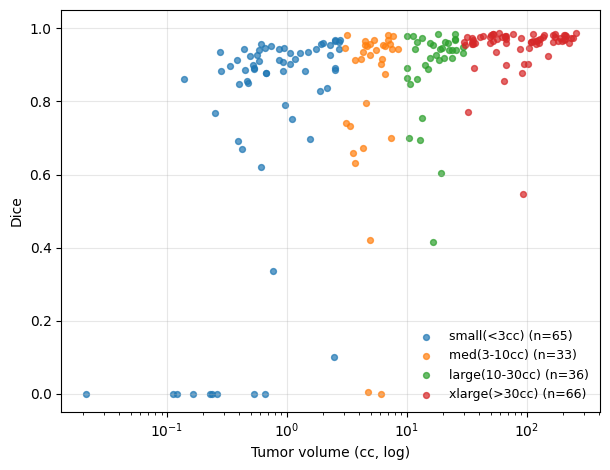

Saved: /content/drive/MyDrive/BraTS_MEN_baseline_v2/dice_vs_volume_scatter.png


/tmp/ipython-input-3633762134.py:98: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=True)


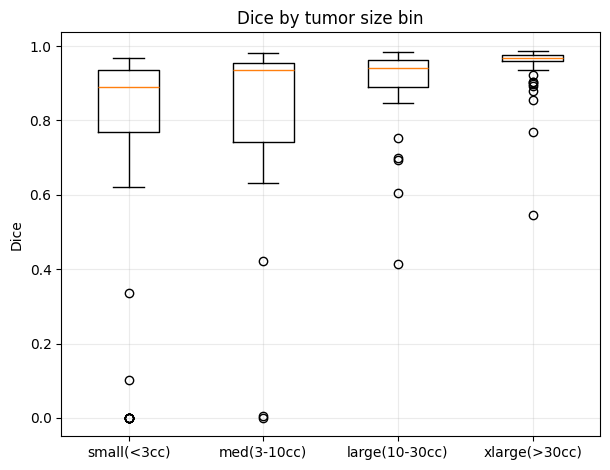

Saved: /content/drive/MyDrive/BraTS_MEN_baseline_v2/dice_box_by_sizebin.png


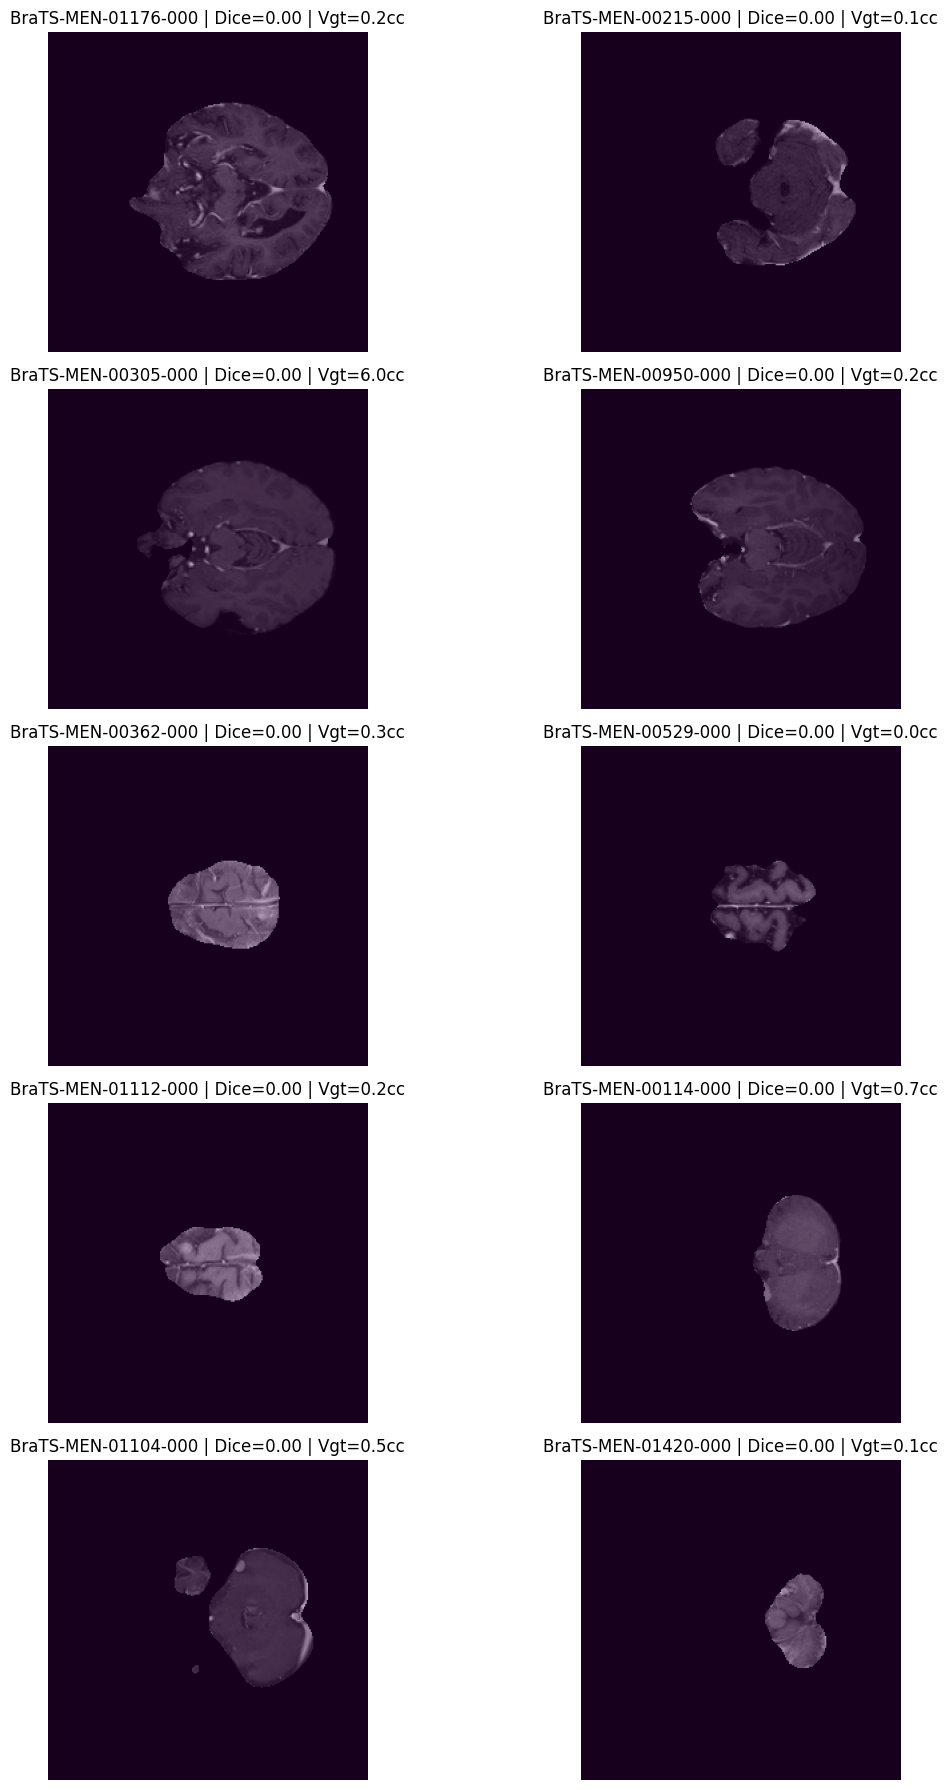

Saved: /content/drive/MyDrive/BraTS_MEN_baseline_v2/worst10_overlay_grid.png


In [ ]:
# ========= Deep dive on failures & size effects =========
# Requirements:
# - SAVE_DIR points to your v2 folder
# - best_thr was chosen earlier (or we infer it from filenames)
# - val_metrics_thrXX.csv exists (written by your previous cell)
#
# Outputs (written to SAVE_DIR):
# - worst10_cases.csv
# - small_medium_large_summary.csv
# - dice_vs_volume_scatter.png
# - dice_box_by_sizebin.png
# - worst10_overlay_grid.png  (optional, if predictions are present)

import re, json, numpy as np, pandas as pd, nibabel as nib, matplotlib.pyplot as plt
from pathlib import Path

# resolve paths / files
SAVE_DIR = Path(globals().get("SAVE_DIR", "/content/drive/MyDrive/BraTS_MEN_baseline_v2"))
# try to detect the "best_thr" from any val_metrics file, else fall back to 0.60
metrics_files = sorted(SAVE_DIR.glob("val_metrics_thr*.csv"))
if not metrics_files:
    raise FileNotFoundError("No val_metrics_thrXX.csv found in SAVE_DIR; run the evaluation cell first.")
metrics_path = metrics_files[0]
m = re.search(r"thr(\d+\.\d+)", metrics_path.name)
best_thr = float(m.group(1)) if m else 0.60
print(f"Using metrics file: {metrics_path.name} (best_thr={best_thr:.2f})")

df = pd.read_csv(metrics_path)
assert {"subject","dice","vol_gt_cc","vol_pred_cc","precision","recall","hd95"}.issubset(df.columns)

# ---------- 1) Worst ~10 cases & Dice<0.30 ----------
# --- ensure numeric dtypes (safe if already numeric) ---
num_cols = ["dice","vol_gt_cc","vol_pred_cc","precision","recall","hd95"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
    worst10[c] = pd.to_numeric(worst10[c], errors="coerce")

def q(arr):
    a = pd.Series(arr).dropna().to_numpy()
    return np.quantile(a, [0.25, 0.5, 0.75]) if len(a) else np.array([np.nan]*3)

print("\n--- Worst 10 summary ---")
d_min, d_med, d_max = worst10["dice"].min(), worst10["dice"].median(), worst10["dice"].max()
print(f"Dice  min/med/max: {d_min:.3f}, {d_med:.3f}, {d_max:.3f}")

q_gt  = q(worst10["vol_gt_cc"])
q_pr  = q(worst10["vol_pred_cc"])
q_hd  = q(worst10["hd95"])
print(f"GT vol (cc) q25/50/75: {q_gt[0]:.3f}, {q_gt[1]:.3f}, {q_gt[2]:.3f}")
print(f"Pred vol (cc) q25/50/75: {q_pr[0]:.3f}, {q_pr[1]:.3f}, {q_pr[2]:.3f}")
print(f"HD95 q25/50/75: {q_hd[0]:.3f}, {q_hd[1]:.3f}, {q_hd[2]:.3f}")

prec_mean = worst10["precision"].mean()
rec_mean  = worst10["recall"].mean()
print(f"Precision mean: {prec_mean:.3f} | Recall mean: {rec_mean:.3f}")

tiny_thr_cc = 3.0
n_tiny = int((worst10["vol_gt_cc"] < tiny_thr_cc).sum())
print(f"Tiny tumors among worst10 (<{tiny_thr_cc} cc): {n_tiny}/{len(worst10)}")


# ---------- 2) Stratify by tumor size ----------
# bins in cubic centimeters; tweak if you like
bins = [0, 3, 10, 30, 1000]
labels = ["small(<3cc)", "med(3-10cc)", "large(10-30cc)", "xlarge(>30cc)"]
df["size_bin"] = pd.cut(df["vol_gt_cc"], bins=bins, labels=labels, right=False)

summary = df.groupby("size_bin").agg(
    n=("dice","size"),
    mean_dice=("dice","mean"),
    median_dice=("dice","median"),
    mean_prec=("precision","mean"),
    mean_recall=("recall","mean"),
    mean_hd95=("hd95","mean"),
).reset_index()
summary_path = SAVE_DIR / "small_medium_large_summary.csv"
summary.to_csv(summary_path, index=False)
print("\nSize-bin summary ->", summary_path)
display(summary)

# ---------- 3) Plots ----------
# 3a) Dice vs GT volume (log-x), color by size bin
plt.figure(figsize=(6.2,4.8))
for lab in labels:
    dd = df[df["size_bin"]==lab]
    if len(dd):
        plt.scatter(dd["vol_gt_cc"], dd["dice"], s=18, alpha=0.7, label=f"{lab} (n={len(dd)})")
plt.xscale("log"); plt.xlabel("Tumor volume (cc, log)"); plt.ylabel("Dice")
plt.ylim(-0.05, 1.05); plt.grid(True, alpha=0.3); plt.legend(frameon=False, fontsize=9)
sc_path = SAVE_DIR / "dice_vs_volume_scatter.png"
plt.tight_layout(); plt.savefig(sc_path, dpi=150); plt.show()
print("Saved:", sc_path)

# 3b) Boxplot of Dice by size bin
plt.figure(figsize=(6.2,4.8))
order = [lab for lab in labels if lab in df["size_bin"].unique()]
data = [df[df["size_bin"]==lab]["dice"].values for lab in order]
plt.boxplot(data, labels=order, showfliers=True)
plt.ylabel("Dice"); plt.title("Dice by tumor size bin"); plt.grid(True, alpha=0.25)
bx_path = SAVE_DIR / "dice_box_by_sizebin.png"
plt.tight_layout(); plt.savefig(bx_path, dpi=150); plt.show()
print("Saved:", bx_path)

# ---------- 4) (Optional) Make a grid of overlays for the worst 10 ----------
# Uses predictions you already saved in predictions_thrXX/ and the original T1c + GT
pred_dir = SAVE_DIR / f"predictions_thr{best_thr:.2f}"
if pred_dir.exists():
    import math

    def overlay_triplet(item_row):
        sid = item_row["subject"]
        # locate corresponding item dict in your split file to get original paths
        split = json.loads((SAVE_DIR / "subject_split.json").read_text())
        item = next(it for it in split["val"] if Path(it["t1c"]).parent.name == sid)

        t1c_np = nib.load(item["t1c"]).get_fdata().astype(np.float32)
        gt_np  = (nib.load(item["seg"]).get_fdata() > 0).astype(np.uint8)
        pred_np = nib.load(pred_dir / f"{sid}_pred_thr{best_thr:.2f}.nii.gz").get_fdata().astype(np.uint8)

        # choose central GT slice or middle if empty
        zs = np.where(gt_np.sum(axis=(0,1))>0)[0]
        z  = int(zs[len(zs)//2]) if len(zs) else gt_np.shape[2]//2
        return t1c_np[:,:,z], gt_np[:,:,z], pred_np[:,:,z], sid

    rows, cols = 5, 2   # 10 cases
    fig = plt.figure(figsize=(cols*6.5, rows*3.6))
    for i in range(min(len(worst10), rows*cols)):
        t1c_s, gt_s, pr_s, sid = overlay_triplet(worst10.iloc[i])
        ax1 = plt.subplot(rows, cols, i+1)
        ax1.imshow(t1c_s, cmap="gray"); ax1.imshow(pr_s, alpha=0.35)
        ax1.set_title(f"{sid} | Dice={worst10.iloc[i]['dice']:.2f} | Vgt={worst10.iloc[i]['vol_gt_cc']:.1f}cc")
        ax1.axis("off")
    grid_path = SAVE_DIR / "worst10_overlay_grid.png"
    plt.tight_layout(); plt.savefig(grid_path, dpi=150); plt.show()
    print("Saved:", grid_path)
else:
    print(f"(skip overlays) {pred_dir} not found. Run the prior cell that writes NIfTI predictions if you want the grid.")


Device: cuda | SAVE_DIR: /content/drive/MyDrive/BraTS_MEN_baseline_v2
Val subjects: 200
[none] mean Dice=0.8464 | 203.8s | saved CSV
[k2] mean Dice=0.8467 | 233.0s | saved CSV
Using results from: k2


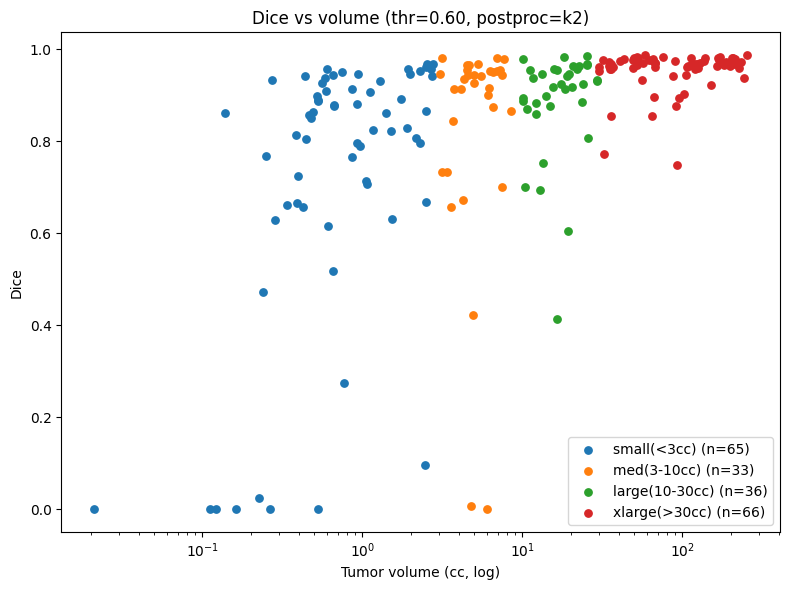

<Figure size 800x600 with 0 Axes>

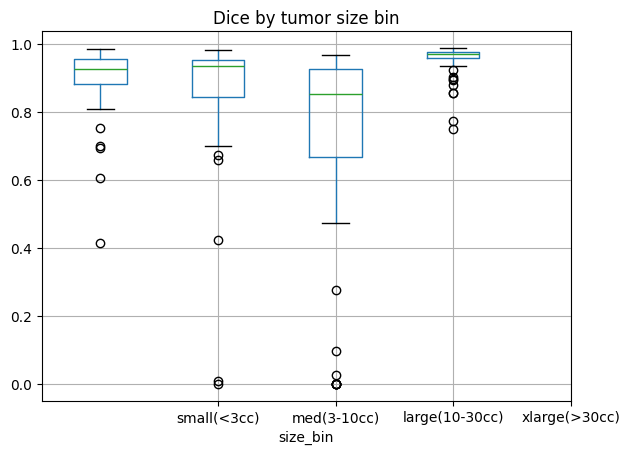

Size-bin summary saved -> /content/drive/MyDrive/BraTS_MEN_baseline_v2/sizebin_summary_k2.csv


/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  out

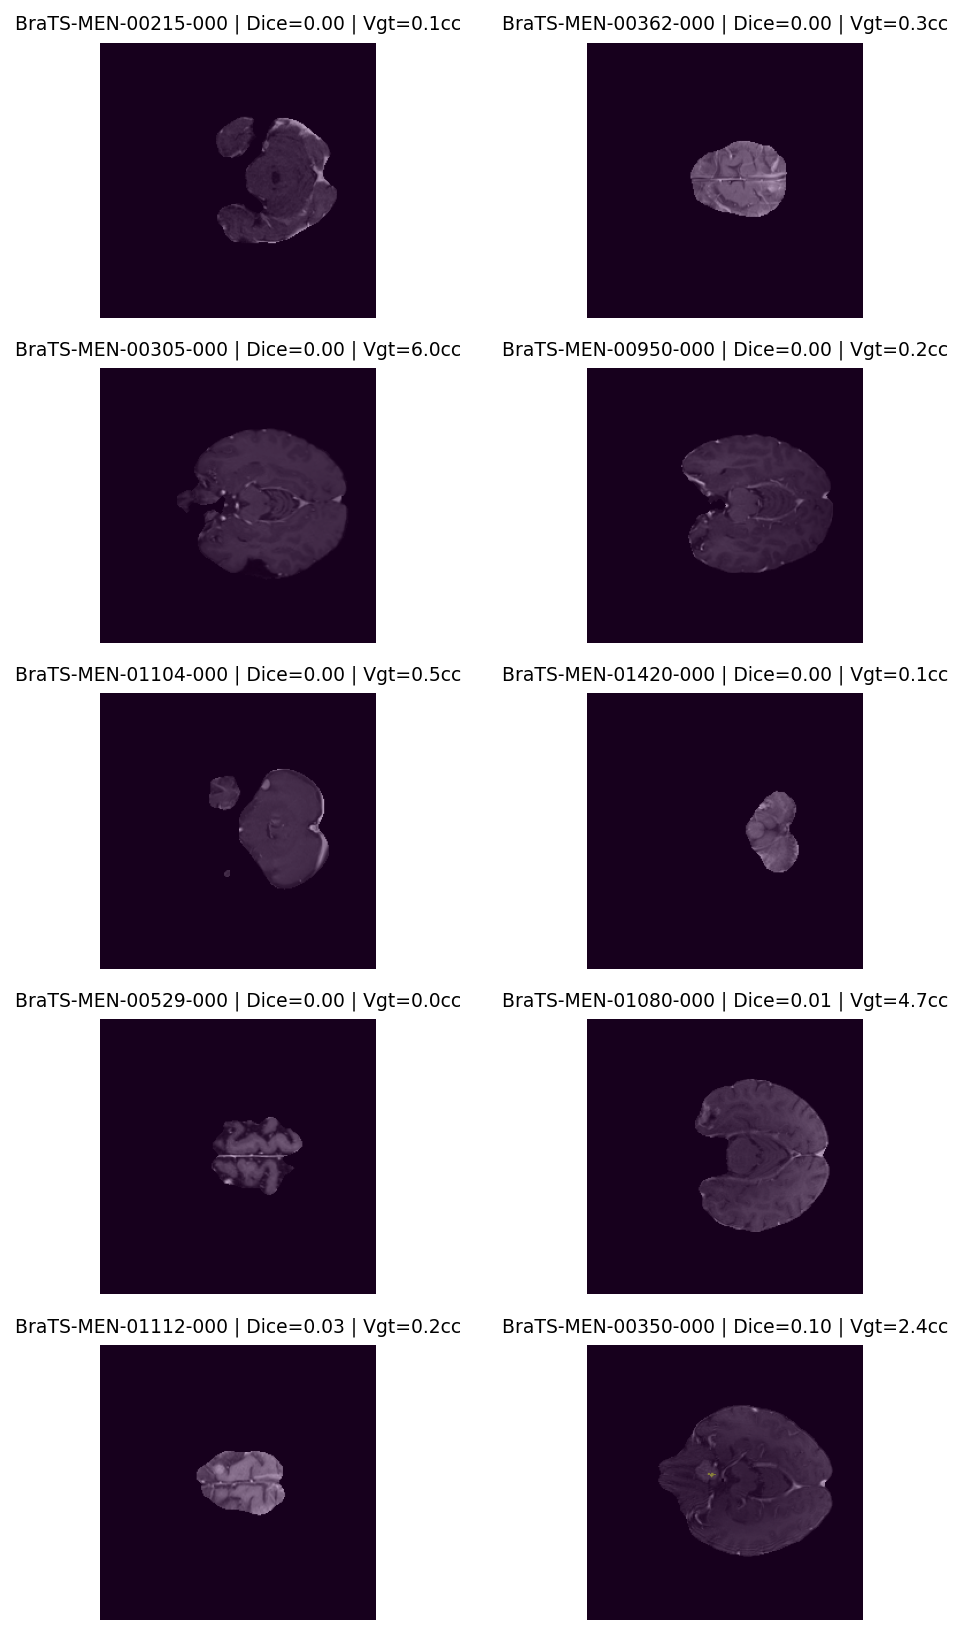

Worst-10 overlay grid saved -> /content/drive/MyDrive/BraTS_MEN_baseline_v2/worst10_overlay_grid_k2.png


In [12]:
# === Quick re-eval: no-LCC vs LCC(top-2) + size strat + worst-10 overlays ===
import os, json, time
from pathlib import Path
import numpy as np, pandas as pd, nibabel as nib
import torch, matplotlib.pyplot as plt
import scipy.ndimage as ndi

import monai
from monai.data import Dataset, DataLoader, list_data_collate
from monai.transforms import (
    Compose, LoadImaged, EnsureTyped, EnsureChannelFirstd, Spacingd,
    NormalizeIntensityd, ConcatItemsd, ToTensord, AsDiscrete,
    KeepLargestConnectedComponent, FillHoles
)
from monai.inferers import sliding_window_inference
from monai.networks.nets import UNet

# ---------------- cfg/paths ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_DIR = Path(globals().get("SAVE_DIR", "/content/drive/MyDrive/BraTS_MEN_baseline_v2"))
CKPT_PATH = SAVE_DIR / "unet3d_v2.pt"
SPLIT_PATH = SAVE_DIR / "subject_split.json"
assert CKPT_PATH.exists(), CKPT_PATH
assert SPLIT_PATH.exists(), SPLIT_PATH

# inference params (defaults if not in memory)
ROI = tuple(globals().get("ROI", (128,128,128)))
SW_OVERLAP = 0.25
SW_BATCH   = 2
THRESH     = 0.60  # from your sweep

print("Device:", device, "| SAVE_DIR:", SAVE_DIR)

# ---------------- data ----------------
payload   = json.loads(Path(SPLIT_PATH).read_text())
val_items = payload["val"]

keys_img = ["t1n","t2w","t2f","t1c"]; key_seg = "seg"
def _binarize(arr):
    import numpy as _np, torch as _t
    if isinstance(arr, _t.Tensor): return (arr > 0).float()
    return (_np.asarray(arr) > 0).astype(_np.float32)

class BinarizeSeg(monai.transforms.MapTransform):
    def __init__(self, keys=("seg",), allow_missing_keys=False):
        super().__init__(keys, allow_missing_keys)
    def __call__(self, data):
        d = dict(data)
        for k in self.keys: d[k] = _binarize(d[k])
        return d

_common = [
    LoadImaged(keys=keys_img+[key_seg], image_only=True),
    EnsureTyped(keys=keys_img+[key_seg]),
    EnsureChannelFirstd(keys=keys_img+[key_seg]),
    Spacingd(keys=keys_img, pixdim=(1,1,1), mode="bilinear"),
    Spacingd(keys=[key_seg],  pixdim=(1,1,1), mode="nearest"),
    BinarizeSeg(keys=(key_seg,)),
    NormalizeIntensityd(keys=keys_img, nonzero=True, channel_wise=True),
]
val_tf   = Compose(_common + [ConcatItemsd(keys=keys_img, name="image", dim=0),
                              ToTensord(keys=["image", key_seg])])
val_ds   = Dataset(val_items, transform=val_tf)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False,
                        num_workers=4, pin_memory=True, persistent_workers=False,
                        collate_fn=list_data_collate)
print("Val subjects:", len(val_ds))

# ---------------- model ----------------
model = UNet(spatial_dims=3, in_channels=4, out_channels=1,
             channels=(32,64,128,256,512), strides=(2,2,2,2), num_res_units=2).to(device)
model.load_state_dict(torch.load(CKPT_PATH, map_location=device))
model.eval()
ampctx = lambda: torch.amp.autocast('cuda', enabled=(device.type=='cuda'))

# ---------------- helpers ----------------
def subj_id(item): return Path(item["t1c"]).parent.name
def volume_cc(mask_np, voxel_mm3=1.0): return float(mask_np.sum() * voxel_mm3 / 1000.0)
def dice_np(pred, gt, eps=1e-8):
    inter = np.logical_and(pred, gt).sum()
    return (2*inter)/(pred.sum()+gt.sum()+eps)

def keep_topk_components(arr, k=2):
    """Keep top-k connected components of a binary 3D numpy array."""
    lbl, num = ndi.label(arr)
    if num == 0: return arr
    sizes = [(lbl == i).sum() for i in range(1, num+1)]
    order = np.argsort(sizes)[::-1][:k]
    keep = np.isin(lbl, (np.asarray(order)+1))
    return keep.astype(np.uint8)

def build_postproc(thr, mode):
    if mode == "none":
        return Compose([AsDiscrete(threshold=float(thr)),
                        FillHoles(applied_labels=[1])])
    elif mode == "k2":
        return Compose([
            AsDiscrete(threshold=float(thr)),
            lambda t: torch.from_numpy(
                keep_topk_components(t.cpu().numpy()[0,0], k=2)[None,None]
            ).to(t.device, dtype=t.dtype),
            FillHoles(applied_labels=[1])
        ])
    else:
        raise ValueError("mode must be 'none' or 'k2'")

def run_eval(mode: str):
    postp = build_postproc(THRESH, mode)
    rows = []
    t0 = time.time()
    with torch.no_grad(), ampctx():
        for i, batch in enumerate(val_loader):
            imgs = batch["image"].to(device)
            segs = batch["seg"].to(device).float()
            logits = sliding_window_inference(imgs, ROI, SW_BATCH, model, overlap=SW_OVERLAP)
            probs  = torch.sigmoid(logits)
            preds  = postp(probs)  # (1,1,D,H,W)
            pred_np = preds[0,0].cpu().numpy().astype(np.uint8)
            gt_np   = segs[0,0].cpu().numpy().astype(np.uint8)

            sid = subj_id(val_items[i])
            rows.append({
                "subject": sid,
                "dice": dice_np(pred_np, gt_np),
                "vol_pred_cc": volume_cc(pred_np),
                "vol_gt_cc":   volume_cc(gt_np),
            })
    dt = time.time()-t0
    df = pd.DataFrame(rows)
    df.to_csv(SAVE_DIR / f"val_metrics_thr{THRESH:.2f}_{mode}.csv", index=False)
    print(f"[{mode}] mean Dice={df['dice'].mean():.4f} | {dt:.1f}s | saved CSV")
    return df

# ---------------- run both variants ----------------
df_none = run_eval("none")
df_k2   = run_eval("k2")

# pick the better one
which = "k2" if df_k2["dice"].mean() >= df_none["dice"].mean() else "none"
df     = df_k2 if which=="k2" else df_none
print(f"Using results from: {which}")

# ---------------- size stratification + plots ----------------
def size_bin(v):
    return ("small(<3cc)" if v<3 else
            "med(3-10cc)" if v<10 else
            "large(10-30cc)" if v<30 else
            "xlarge(>30cc)")

df["size_bin"] = df["vol_gt_cc"].apply(size_bin)

# scatter Dice vs volume
plt.figure(figsize=(8,6))
for b,c in zip(["small(<3cc)","med(3-10cc)","large(10-30cc)","xlarge(>30cc)"],
               ["C0","C1","C2","C3"]):
    sub = df[df["size_bin"]==b]
    if len(sub):
        plt.scatter(np.clip(sub["vol_gt_cc"].values,1e-3,None), sub["dice"].values, s=28, label=f"{b} (n={len(sub)})")
plt.xscale("log"); plt.xlabel("Tumor volume (cc, log)"); plt.ylabel("Dice"); plt.legend()
plt.title(f"Dice vs volume (thr={THRESH:.2f}, postproc={which})")
plt.tight_layout()
plt.savefig(SAVE_DIR / f"dice_vs_volume_{which}.png", dpi=150); plt.show()

# boxplot by size bin
order = ["small(<3cc)","med(3-10cc)","large(10-30cc)","xlarge(>30cc)"]
plt.figure(figsize=(8,6))
df.boxplot(column="dice", by="size_bin", positions=[0,1,2,3])
plt.xticks(range(1,5), order); plt.suptitle(""); plt.title("Dice by tumor size bin")
plt.tight_layout()
plt.savefig(SAVE_DIR / f"dice_box_by_sizebin_{which}.png", dpi=150); plt.show()

# save per-size-bin summary csv
summ = df.groupby("size_bin").agg(
    n=("dice","count"), dice_mean=("dice","mean"), dice_median=("dice","median"),
    vol_median=("vol_gt_cc","median")
).reset_index()
summ.to_csv(SAVE_DIR / f"sizebin_summary_{which}.csv", index=False)
print("Size-bin summary saved ->", SAVE_DIR / f"sizebin_summary_{which}.csv")

# ---------------- worst-10 overlay grid ----------------
def central_slice_from_gt(gt_np):
    zs = np.where(gt_np.sum(axis=(0,1))>0)[0]
    return int(zs[len(zs)//2]) if len(zs) else gt_np.shape[2]//2

def overlay_ax(ax, t1c_np, gt_np, pred_np, z, title):
    ax.imshow(t1c_np[:,:,z], cmap="gray")
    ax.imshow(pred_np[:,:,z], alpha=0.35)
    ax.set_title(title, fontsize=9); ax.axis("off")

worst = df.sort_values("dice").head(10).copy()
fig, axes = plt.subplots(5,2, figsize=(8,11), dpi=150)
axes = axes.ravel()
for i, row in enumerate(worst.itertuples()):
    sid = row.subject
    item = next(it for it in val_items if subj_id(it)==sid)
    t1c_np = nib.load(item["t1c"]).get_fdata().astype(np.float32)
    gt_np  = (nib.load(item["seg"]).get_fdata()>0).astype(np.uint8)

    with torch.no_grad(), ampctx():
        batch = val_tf(item)
        img = batch["image"].unsqueeze(0).to(device)
        logits = sliding_window_inference(img, ROI, SW_BATCH, model, overlap=SW_OVERLAP)
        probs  = torch.sigmoid(logits)
        pred_np = build_postproc(THRESH, which)(probs)[0,0].cpu().numpy().astype(np.uint8)

    z = central_slice_from_gt(gt_np)
    title = f"{sid} | Dice={row.dice:.2f} | Vgt={row.vol_gt_cc:.1f}cc"
    overlay_ax(axes[i], t1c_np, gt_np, pred_np, z, title)

for j in range(len(worst), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
grid_path = SAVE_DIR / f"worst10_overlay_grid_{which}.png"
plt.savefig(grid_path, dpi=150); plt.show()
print("Worst-10 overlay grid saved ->", grid_path)
